# Amazon Fine Food Review- Using Naive Bayes


In [1]:
#import all we needed module
import numpy as np
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import model_selection
#from sklearn import cross_validation******** this is not working
from collections import Counter
from sklearn.naive_bayes import MultinomialNB

In [2]:
import sqlite3
con = sqlite3.connect('finalassignment.sqlite')

In [3]:
cleaned_data = pd.read_sql_query('select * from Reviews', con)

In [4]:
cleaned_data.shape

(364171, 12)

In [5]:
cleaned_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [6]:
# To randomly sample 5k points from both class

data_p = cleaned_data[cleaned_data['Score'] == 'positive'].sample(n = 5000)
data_n = cleaned_data[cleaned_data['Score'] == 'negative'].sample(n = 5000)
final_10k = pd.concat([data_p, data_n])
final_10k.shape

(10000, 12)

In [7]:
# Sorting data based on time
final_10k['Time'] = pd.to_datetime(final_10k['Time'], unit = 's')
final_10k = final_10k.sort_values(by = 'Time')

#  Bag Of Word (BOW)

In [8]:
# function compute the alpha value 

def naive_bayes(X_train , y_train):
    
    alpha_value = np.arange(1,500,0.5)
    
    # empty list that will hold cv value
    cv_scores = []
    
    #perform 10-fold cross validation
    for alpha in alpha_value:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb , X_train , y_train , cv = 10 , scoring = 'accuracy')
        cv_scores.append(scores.mean())
        
    # changing misclassification error
    MSE = [1 - x for x in cv_scores]
    
    #determining best alpha
    optimal_alpha = alpha_value[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d :'% optimal_alpha)
    
    #plot misclassification error vs alpha
    plt.plot(alpha_value ,MSE , marker = '*')
    
   
    #for xy in zip(alpha_values, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    return optimal_alpha

In [39]:
# 10k data which will use to train model after vectorization
X = final_10k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (10000,)


In [40]:
# class label
y = final_10k["Score"]
print("shape of y:", y.shape)

shape of y: (10000,)


In [41]:
# split data into train and test where 70% data used to train model and 30% for test

from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape , y_test.shape)

(7000,) (7000,) (3000,) (3000,)


In [42]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<7000x12436 sparse matrix of type '<class 'numpy.int64'>'
	with 214288 stored elements in Compressed Sparse Row format>

In [43]:
# convert test text data to its vectorizor
x_test = bow.transform(x_test)

In [44]:
x_test.shape

(3000, 12436)


The optimal number of alpha is 10 :


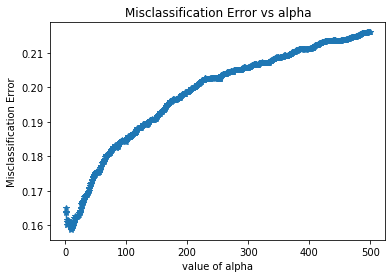

10.5

In [45]:
# To choose optimal_alpha using cross validation

from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection


optimal_alpha_bow = naive_bayes(X_train, y_train)
optimal_alpha_bow

In [46]:
# instantiate learning model alpha = optimal_alpha
nb_optimal =  MultinomialNB(alpha = optimal_alpha_bow)

# fitting the model
nb_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = nb_optimal.predict(x_test)

now this six stape not need find for find train and test accuracy but only find to log proobability and our understading.


In [70]:
# to get all feature name

bow_features = bow.get_feature_names()

In [73]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 12338)

In [74]:
# Number of samples encountered for each class during fitting

nb_optimal.class_count_

array([3523., 3477.])

In [78]:
# Empirical log probability  of feature given a class 

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-10.38732364, -10.38732364, -10.38732364, ..., -10.0306487 ,
        -10.38732364, -10.38732364],
       [-10.20574261, -10.20574261, -10.20574261, ..., -10.20574261,
        -10.20574261, -10.20574261]])

In [80]:
feature_prob = pd.DataFrame(log_prob , columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(12338, 2)

In [84]:
# to show top 10 feature from both class
#feature Impportance

print('Top 10 Negative Feature :', feature_prob_tr[0].sort_values(ascending = False)[0:10])
print('------------------------------------------------------------------------------------')
print('Top 10 Postive Feature : ', feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Feature : tast      -4.674062
like      -4.759189
product   -4.841031
flavor    -5.134303
one       -5.223354
would     -5.241492
tri       -5.300610
use       -5.450796
good      -5.546517
food      -5.564741
Name: 0, dtype: float64
------------------------------------------------------------------------------------
Top 10 Postive Feature :  like      -4.918107
tast      -4.984036
love      -5.127449
flavor    -5.153486
good      -5.166358
use       -5.185982
great     -5.218717
one       -5.270370
product   -5.332456
tea       -5.332456
Name: 1, dtype: float64


Now above six step is find probabilit for any word so this not impect in train and test acc...
this for only understanding purpose......................

In [47]:
# Accuracy on train data
train_acc_bow = nb_optimal.score(X_train, y_train)
print("Train accuracy : %f%%" % (train_acc_bow))

Train accuracy : 0.881857%


In [48]:
# Error on train data
train_err_bow = 1-train_acc_bow 
print("Train Error %f%%" % (train_err_bow))

Train Error 0.118143%


In [49]:
# evaluate accuracy on test data
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_bow, acc_bow))


The accuracy of the naive bayes classifier for alpha = 10 is 83.700000%


In [50]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1332,  189],
       [ 300, 1179]], dtype=int64)

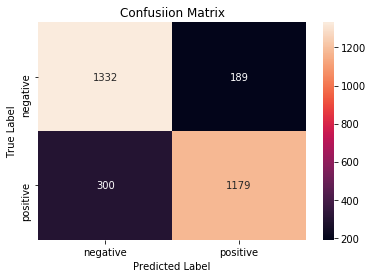

In [51]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [52]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.82      0.88      0.84      1521
    positive       0.86      0.80      0.83      1479

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [53]:
# model for knn with bag of word
models = pd.DataFrame({'Model': ['Naive Bayes with Bow'], 'Hyper Parameter(K)': [optimal_alpha_bow], 'Train Error': [train_err_bow], 'Test Error': [100-acc_bow], 'Accuracy': [acc_bow ], 'Train Accuracy': [train_acc_bow ]}, columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy" , "Train Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy,Train Accuracy
0,Naive Bayes with Bow,10.5,0.118143,16.3,83.7,0.881857


# TF - IDF

In [12]:
# # 10k data which will use to train model after vectorization

X = final_10k['CleanedText']
X.shape

(10000,)

In [13]:
# target / class label

y = final_10k['Score']
y.shape

(10000,)

In [15]:
#split data

X_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.3 , random_state = 42)
print(X_train.shape , x_test.shape , y_train.shape , y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [16]:
# Train Vectorizor

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<7000x178840 sparse matrix of type '<class 'numpy.float64'>'
	with 462779 stored elements in Compressed Sparse Row format>

In [17]:
# convert test data to its vectorizor

x_test = tf_idf_vect.transform(x_test)
x_test.shape

(3000, 178840)


The optimal number of alpha is 1 :


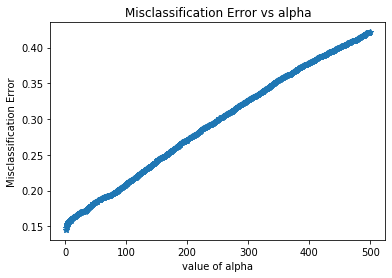

1.0

In [21]:
# to chossing optimal alpha using cv

from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection


optimal_alpha_tfidf = naive_bayes(X_train, y_train)
optimal_alpha_tfidf

In [22]:
# instantiate learning model alpha = optimal_alpha
nb_optimal = MultinomialNB(alpha = optimal_alpha_tfidf)

# fitting the model
nb_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = nb_optimal.predict(x_test)

we find to log probability so its not effect on accuracy data........

In [31]:
# To get all the features name 

tfidf_features = tf_idf_vect.get_feature_names()

In [32]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 178840)

In [33]:
# Number of samples encountered for each class during fitting

nb_optimal.class_count_

array([3479., 3521.])

In [34]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-12.15099768, -12.22690389, -12.14503183, ..., -12.07860366,
        -12.07860366, -12.22690389],
       [-12.14035824, -12.17285719, -12.22211498, ..., -12.22211498,
        -12.22211498, -12.068699  ]])

In [35]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(178840, 2)

In [37]:
# to show top 10 feature from both class
#feature Impportance

print('Top 10 Negative Feature :', feature_prob_tr[0].sort_values(ascending = False)[0:10])
print('------------------------------------------------------------------------------------')
print('Top 10 Postive Feature : ', feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Feature : tast      -7.919842
like      -8.077670
product   -8.099889
flavor    -8.409134
coffe     -8.422279
one       -8.447979
would     -8.476220
order     -8.556080
tri       -8.577210
buy       -8.579295
Name: 0, dtype: float64
------------------------------------------------------------------------------------
Top 10 Postive Feature :  great     -8.085772
love      -8.100684
good      -8.210502
like      -8.255778
flavor    -8.261841
tast      -8.272213
tea       -8.284056
coffe     -8.312026
use       -8.385938
product   -8.485452
Name: 1, dtype: float64


Now above 6 line is only for log probanility....
without use this we find our accuracy and error also....
this is for only understanding purpose...........
now we write a accuracy code...

In [23]:
# Accuracy on train data
train_acc_tfidf = nb_optimal.score(X_train, y_train)
print("Train accuracy : %f%%" % (train_acc_tfidf))

Train accuracy : 0.988714%


In [24]:
# Error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

Train Error 0.011286%


In [25]:
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_tfidf, acc_tfidf))


The accuracy of the naive bayes classifier for alpha = 1 is 84.533333%


In [26]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1279,  242],
       [ 222, 1257]], dtype=int64)

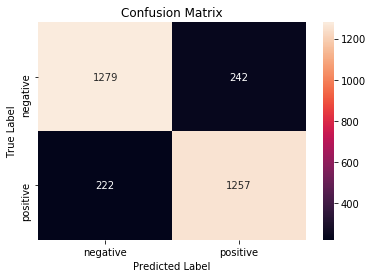

In [28]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.85      0.84      0.85      1521
    positive       0.84      0.85      0.84      1479

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



In [30]:
# model for knn with bag of word
models = pd.DataFrame({'Model': ['Naive Bayes with Tf-Idf'], 'Hyper Parameter(K)': [optimal_alpha_tfidf], 'Train Error': [train_err_tfidf], 'Test Error': [100-acc_tfidf], 'Accuracy': [acc_tfidf ], 'Train Accuracy': [train_acc_tfidf ]}, columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy" , "Train Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy,Train Accuracy
0,Naive Bayes with Tf-Idf,1.0,0.011286,15.466667,84.533333,0.988714


**Conclusions:-**
1. Naive bayes are good at text classification task like spam filtering, sentimental analysis, RS etc. 
2. As we know when a model performs good on training data but poor performence on unseen data(test data)i.e. its dependent on training data only, tends to overfits and when a model perform poor performence on training data and good performence on test data i.e. it fails to learn relationship in training data tends to underfit. We need to balance between both i.e. reduce training error and balance error between both training and testing which is balanced in this case.
3. Another concept bias vs variance is also related with underfitting and overfitting. when a model has high bias and low variance tend to underfitting and its reverse- high variance and low bias called overfitting and we balanced using cross-validataion. As it is shown in below table where both models have low trainig error and test error.
4. overall, both of the models are performing well on unseen data.
5. As we are not applying naive bayes on word2vec representation because it sometimes gives -ve value(i.e. if two word have 0 cosine similarity the word is completly orthogonal i.e. they are not related with each other. and 1 represents perfect relationship between word vector. whereas -ve similarity means they are perfect opposite relationship between word) and we know naive bayes assume that presence of a particular feature in a class is unrelated to presence of any other feature, which is most unlikely in real word. Although, it works well.
6. And from point # 5, features are dependent or there are relationship between features. So applying naive bayes on dependent feature does not make any sense.

In [54]:
# model performence table
models = pd.DataFrame({'Model': ['Naive Bayes with Bow', "Naive Bayes with TFIDF"], 'Hyper Parameter(alpha)': [optimal_alpha_bow, optimal_alpha_tfidf], 'Train Error': [train_err_bow, train_err_tfidf], 'Test Error': [100-acc_bow, 100-acc_tfidf], 'Accuracy': [acc_bow, acc_tfidf]}, columns = ["Model", "Hyper Parameter(alpha)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(alpha),Train Error,Test Error,Accuracy
1,Naive Bayes with TFIDF,1.0,0.011286,15.466667,84.533333
0,Naive Bayes with Bow,10.5,0.118143,16.300000,83.700000
